# Определение перспективного тарифа для телеком компании

## Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
### Тариф «Смарт»
Ежемесячная плата: 
1. 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
<br>- минута разговора: 3 рубля
<br>- сообщение: 3 рубля
<br>- 1 Гб интернет-трафика: 200 рублей</br>

### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
<br>-минута разговора: 1 рубль
<br>-сообщение: 1 рубль
<br>-1 Гб интернет-трафика: 150 рублей

### Обратите внимание: 
«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

In [1]:
import pandas as pd
users = pd.read_csv('users.csv')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [2]:
print(users['city'].value_counts().head(10)) #из каких городов наши пользователи

Москва              99
Санкт-Петербург     39
Новосибирск         16
Казань              14
Омск                14
Уфа                 12
Екатеринбург        11
Набережные Челны    11
Ульяновск           11
Краснодар           11
Name: city, dtype: int64


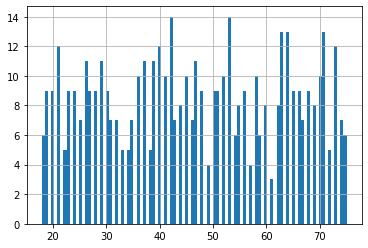

In [3]:
users['age'].hist(bins=100) #посмотрим на распределение возрастов

#### Наши пользователи - это люди всех возрастов из многих городов России, преимущественно из Москвы (20%) и других крупных городов миллионников. По убыванию - Спб, Новосиб, Омск, Казань, Уфа, Екб и тд.

In [4]:
#оставим только необходимые нам столбцы
users = users[['user_id', 'city', 'tariff']]
users.head()

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


In [5]:
calls = pd.read_csv('calls.csv')
#Заменим форматы столбцов с датой и временем и длительностью звонка
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
calls['duration'] = calls['duration'].astype('int')

#### Почти 20% звонков (48к строк из 206к) имеют длительность 0 сек. Это немало, но т.к. табличка со звонками изолированна от остальных данных, то можно удалить эти строки, не потяряв другие значительные данные. Скорее всего это какие-либо ошибки учета звонков, при котором, неотвеченный звонок фиксируется как звонок с нулевым временем или просто ошибки выгрузки. Нам такие строки не нужны. Удаляем их с легким сердцем, т.к. у нас еще остаётся выборка на 154 000 строк для анализа)

In [6]:
calls = calls.query('duration != 0') # оставим таблицу без нулевых звонков
calls.head()

,id,call_date,duration,user_id
2,1000_2,2018-06-11,2,1000
3,1000_3,2018-09-21,13,1000
4,1000_4,2018-12-15,5,1000
7,1000_7,2018-08-22,18,1000
8,1000_8,2018-09-15,18,1000


In [7]:
#добавим столбец с месяцем
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
2,1000_2,2018-06-11,2,1000,6
3,1000_3,2018-09-21,13,1000,9
4,1000_4,2018-12-15,5,1000,12
7,1000_7,2018-08-22,18,1000,8
8,1000_8,2018-09-15,18,1000,9


In [8]:
calls = calls[['user_id','duration','month']] #оставим в таблице только необходимые данные 
calls.head()

,user_id,duration,month
2,1000,2,6
3,1000,13,9
4,1000,5,12
7,1000,18,8
8,1000,18,9


### Cгруппируем данные и найдем сумарное время разговора для каждого пользователя по месяцам

In [9]:
calls_gr = calls.groupby(['user_id','month'])['duration'].sum().copy()
calls_gr = calls_gr.reset_index(level = 'month')
calls_gr.columns = ['month','min']
calls_gr.head()

,month,min
user_id,,
1000,5,142
1000,6,144
1000,7,299
1000,8,367
1000,9,421


In [10]:
messages = pd.read_csv('messages.csv')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [11]:
#добавим столбец с месяцем
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head()

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12


In [12]:
messages = messages[['id','user_id','month']]
messages.head()

,id,user_id,month
0,1000_0,1000,6
1,1000_1,1000,10
2,1000_2,1000,8
3,1000_3,1000,6
4,1000_4,1000,12


### Cгруппируем данные и найдем сколько сообщений каждый пользователь отправлял каждый месяц

In [13]:
messages_gr = messages.groupby(['user_id','month'])['id'].count()
messages_gr = messages_gr.reset_index(level = 'month')
messages_gr.columns = ['month','sms']
messages_gr.head()

,month,sms
user_id,,
1000,5,22
1000,6,60
1000,7,75
1000,8,81
1000,9,57


In [14]:
internet = pd.read_csv('internet.csv')
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')

In [15]:
len(internet.query('mb_used == 0'))

19598

#### 19 тыс. строк (13%) имеют нулевые значения по кол-ву использованного трафика. Т.е. 13% интернет-сессий не "съели" трафика вообще). Я не знаю, что у провайдера является фактом открытия интренет сессии, но даже просто открытие стартовой страницы яндекса, уже сколько-то трафика должно использовать. Я удалю нулевые строки, на ход исследования это сильно не повлияет, т.к. в нашем распоряжении еще 130 тыс. строк для анализа

In [16]:
internet = internet.query('mb_used != 0') # оставим таблицу без нулевых сессий
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [17]:
#добавим столбец с месяцем
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 

In [18]:
#Оставим в таблице только необходимые данные
internet = internet[['user_id','month','mb_used']]
internet.head()

,user_id,month,mb_used
0,1000,11,112.95
1,1000,9,1052.81
2,1000,6,1197.26
3,1000,8,550.27
4,1000,9,302.56


### Cгруппируем данные и найдем сколько трафика каждый пользователь тратил по месяцам

In [19]:
internet_gr = internet.groupby(['user_id','month'])['mb_used'].sum()
internet_gr = internet_gr.reset_index(level = 'month')
internet_gr.columns = ['month','gb']
import numpy as np
internet_gr['gb'] = np.ceil(internet_gr['gb'] / 1024)
internet_gr.head()

,month,gb
user_id,,
1000,5,3.0
1000,6,23.0
1000,7,14.0
1000,8,14.0
1000,9,15.0


In [20]:
tariffs = pd.read_csv('tariffs.csv')
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs.columns = ['sms_lim', 'gb_lim', 'min_lim',
       'price', 'gb_rub', 'sms_rub', 'min_rub',
       'tariff']
print(tariffs.head())

   sms_lim  gb_lim  min_lim  price  gb_rub  sms_rub  min_rub tariff
0       50    15.0      500    550     200        3        3  smart
1     1000    30.0     3000   1950     150        1        1  ultra


### Составим общую таблицу для расчета прибыли

In [21]:
user_calls = users.merge(calls_gr, on='user_id', how='left')
user_calls.head()

,user_id,city,tariff,month,min
0,1000,Краснодар,ultra,5.0,142.0
1,1000,Краснодар,ultra,6.0,144.0
2,1000,Краснодар,ultra,7.0,299.0
3,1000,Краснодар,ultra,8.0,367.0
4,1000,Краснодар,ultra,9.0,421.0


In [22]:
user_calls_message = user_calls.merge(messages_gr, on=['user_id','month'], how='left')
user_calls_message.head()

,user_id,city,tariff,month,min,sms
0,1000,Краснодар,ultra,5.0,142.0,22.0
1,1000,Краснодар,ultra,6.0,144.0,60.0
2,1000,Краснодар,ultra,7.0,299.0,75.0
3,1000,Краснодар,ultra,8.0,367.0,81.0
4,1000,Краснодар,ultra,9.0,421.0,57.0


In [23]:
user_calls_message_inet = user_calls_message.merge(internet_gr, on=['user_id','month'], how='left')
user_calls_message_inet = user_calls_message_inet.fillna(0) #заменим пустые значения на нули
user_calls_message_inet.head()

,user_id,city,tariff,month,min,sms,gb
0,1000,Краснодар,ultra,5.0,142.0,22.0,3.0
1,1000,Краснодар,ultra,6.0,144.0,60.0,23.0
2,1000,Краснодар,ultra,7.0,299.0,75.0,14.0
3,1000,Краснодар,ultra,8.0,367.0,81.0,14.0
4,1000,Краснодар,ultra,9.0,421.0,57.0,15.0


### Добавим в общую таблицу условия тарифов

In [24]:
pivot = user_calls_message_inet.merge(tariffs, on='tariff', how='left')
pivot.head()

,user_id,city,tariff,month,min,sms,gb,sms_lim,gb_lim,min_lim,price,gb_rub,sms_rub,min_rub
0,1000,Краснодар,ultra,5.0,142.0,22.0,3.0,1000,30.0,3000,1950,150,1,1
1,1000,Краснодар,ultra,6.0,144.0,60.0,23.0,1000,30.0,3000,1950,150,1,1
2,1000,Краснодар,ultra,7.0,299.0,75.0,14.0,1000,30.0,3000,1950,150,1,1
3,1000,Краснодар,ultra,8.0,367.0,81.0,14.0,1000,30.0,3000,1950,150,1,1
4,1000,Краснодар,ultra,9.0,421.0,57.0,15.0,1000,30.0,3000,1950,150,1,1


##### Зададим функцию, которая будет возвращать 0, если число отрицательное, иначе будет возвращать само это число, если оно положительное

In [25]:
def func(x):
    if x < 0:
        return 0
    else:
        return x
    
# Добавим столбцы с перерасходом тарифных единиц

pivot['min_exc'] = (pivot['min'] - pivot['min_lim']).apply(func)
pivot['sms_exc'] = (pivot['sms'] - pivot['sms_lim']).apply(func)
pivot['gb_exc'] = (pivot['gb'] - pivot['gb_lim']).apply(func)
pivot.tail()

,user_id,city,tariff,month,min,sms,gb,sms_lim,gb_lim,min_lim,price,gb_rub,sms_rub,min_rub,min_exc,sms_exc,gb_exc
3169,1498,Владикавказ,smart,10.0,218.0,42.0,21.0,50,15.0,500,550,200,3,3,0.0,0.0,6.0
3170,1499,Пермь,smart,9.0,62.0,11.0,2.0,50,15.0,500,550,200,3,3,0.0,0.0,0.0
3171,1499,Пермь,smart,10.0,406.0,48.0,18.0,50,15.0,500,550,200,3,3,0.0,0.0,3.0
3172,1499,Пермь,smart,11.0,550.0,59.0,18.0,50,15.0,500,550,200,3,3,50.0,9.0,3.0
3173,1499,Пермь,smart,12.0,436.0,66.0,13.0,50,15.0,500,550,200,3,3,0.0,16.0,0.0


#### Добавим столбец с прибылью

In [26]:
pivot['profit'] = (pivot['min_exc'] * pivot['min_rub']) + (pivot['sms_exc'] * pivot['sms_rub']) + (pivot['gb_exc'] * pivot['gb_rub']) + pivot['price']

pivot.tail()

,user_id,city,tariff,month,min,sms,gb,sms_lim,gb_lim,min_lim,price,gb_rub,sms_rub,min_rub,min_exc,sms_exc,gb_exc,profit
3169,1498,Владикавказ,smart,10.0,218.0,42.0,21.0,50,15.0,500,550,200,3,3,0.0,0.0,6.0,1750.0
3170,1499,Пермь,smart,9.0,62.0,11.0,2.0,50,15.0,500,550,200,3,3,0.0,0.0,0.0,550.0
3171,1499,Пермь,smart,10.0,406.0,48.0,18.0,50,15.0,500,550,200,3,3,0.0,0.0,3.0,1150.0
3172,1499,Пермь,smart,11.0,550.0,59.0,18.0,50,15.0,500,550,200,3,3,50.0,9.0,3.0,1327.0
3173,1499,Пермь,smart,12.0,436.0,66.0,13.0,50,15.0,500,550,200,3,3,0.0,16.0,0.0,598.0


In [27]:
pivot.head(10)

,user_id,city,tariff,month,min,sms,gb,sms_lim,gb_lim,min_lim,price,gb_rub,sms_rub,min_rub,min_exc,sms_exc,gb_exc,profit
0,1000,Краснодар,ultra,5.0,142.0,22.0,3.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
1,1000,Краснодар,ultra,6.0,144.0,60.0,23.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
2,1000,Краснодар,ultra,7.0,299.0,75.0,14.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
3,1000,Краснодар,ultra,8.0,367.0,81.0,14.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
4,1000,Краснодар,ultra,9.0,421.0,57.0,15.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
5,1000,Краснодар,ultra,10.0,306.0,73.0,15.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
6,1000,Краснодар,ultra,11.0,301.0,58.0,15.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
7,1000,Краснодар,ultra,12.0,295.0,70.0,10.0,1000,30.0,3000,1950,150,1,1,0.0,0.0,0.0,1950.0
8,1001,Москва,smart,11.0,385.0,0.0,18.0,50,15.0,500,550,200,3,3,0.0,0.0,3.0,1150.0
9,1001,Москва,smart,12.0,367.0,0.0,14.0,50,15.0,500,550,200,3,3,0.0,0.0,0.0,550.0


### Найдем ср.знач, дисперсию и станд. отклонение в распределениях величин по тарифам

## Тариф Smart

### 1. Пакет минут

In [28]:
import numpy as np
smart_min = pivot.query('tariff == "smart"').groupby('user_id')['min'].mean()
smart_min_mean = smart_min.mean()
smart_min_mean #среднее количество минут в месяц

371.89413508302397

In [29]:
smart_min_disp = np.var(smart_min) #дисперсия
smart_min_std = np.std(smart_min)  #стандартное отклонение
smart_min_std

130.25494725811097

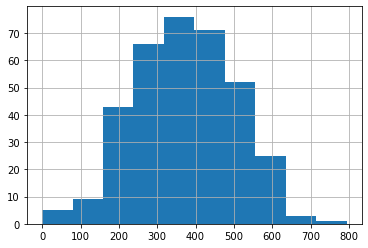

In [30]:
smart_min.hist()

#### Мы видим, что график имеет нормальное распределение, а для нормального распределения работает правило 3-х сигм. Т.е. 68% значений находится в интервале плюс/минус одно стандартное отклонение от среднего = [241,501]. Визуально на графике тоже видно, что большая часть значений падает в интервал от 250 до 550 минут.
#### ИТОГО 83% (по правилу 3-х сигм) пользователям хватает 500 минут на месяц, т.е. можно удтверждать, что оператор связи довольно правильно взял верхнюю границу минут, чтобы удовлетворить потребности большинства. Конечно опертор мог бы взять за верхнюю границу и среднее значение + 3 сигмы, чтобы охватить 99% пользователей, но тода не было бы небольшого зазора (17%) для дополнительного заработка :)

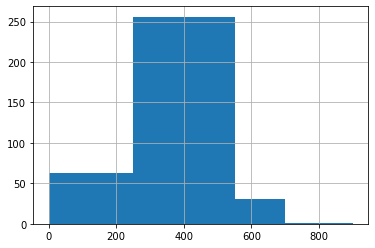

In [31]:
smart_min.hist(bins=[0,250,550,700,900])

### 1. Пакет sms

In [32]:
smart_sms = pivot.query('tariff == "smart"').groupby('user_id')['sms'].mean()
smart_sms_mean = smart_sms.mean()
smart_sms_mean #среднее количество sms в месяц

32.19406344684123

In [33]:
smart_sms_disp = np.var(smart_sms) #дисперсия
smart_sms_std = np.std(smart_sms)  #стандартное отклонение
smart_sms_std

26.549151312609585

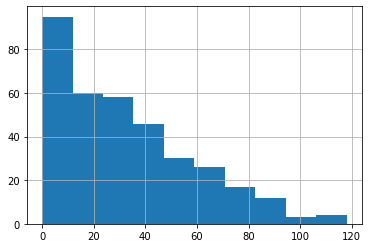

In [34]:
smart_sms.hist()

#### В случае с смс мы видим, что немалая часть ими вообще не пользуется. Но остаётся и много тех, кому они нужны. График представляет собой распределение Пуассона, стандартное отклонение получается большое.  31 + 26 = 57, столько смс хватит для 83% пользователей. В стандартном пакете 50 смс, что в принципе тоже нормально, чтобы покрыть потребности большинства.

### 1. Пакет GB

In [35]:
smart_gb = pivot.query('tariff == "smart"').groupby('user_id')['gb'].mean()
smart_gb_mean = smart_gb.mean()
smart_gb_mean #среднее количество sms в месяц

16.22030212585768

In [36]:
smart_gb_disp = np.var(smart_gb) #дисперсия
smart_gb_std = np.std(smart_gb)  #стандартное отклонение
smart_gb_std

3.7079540893656264

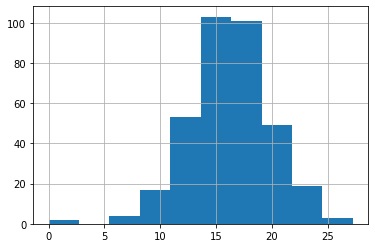

In [37]:
smart_gb.hist(bins=10)

#### нормальное распределение. 68% хватит от 12,5 до 20 GB трафика (интервал среднее +/- сигма). Или можно сказать, что 83% хватит 20GB.  

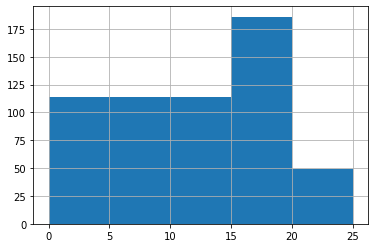

In [38]:
smart_gb.hist(bins=[0,15,20,25])

### Вывод: Исходя из исследования в месяц большему числу пользователей тарифа смарт нужно:
#### - 500  минут
#### - 57  смс
#### - 20   gb
####  В принципе этот тариф вполне удовлетворяет запросы пользователей. Единственное, что интернета можно накинуть побольше, чтобы не потерять пользователей.

## Тариф Ultra

In [39]:
ultra_min = pivot.query('tariff == "ultra"').groupby('user_id')['min'].mean()
ultra_min_mean = ultra_min.mean()
ultra_min_mean #среднее количество минут в месяц
ultra_min_disp = np.var(ultra_min) #дисперсия
ultra_min_std = np.std(ultra_min)  #стандартное отклонение
print(ultra_min_mean) #среднее количество минут в месяц
print(ultra_min_std)

467.6389373117562
251.6764199792085


In [40]:
ultra_sms = pivot.query('tariff == "ultra"').groupby('user_id')['sms'].mean()
ultra_sms_mean = ultra_sms.mean()
ultra_sms_mean #среднее количество sms в месяц
ultra_sms_disp = np.var(ultra_sms) #дисперсия
ultra_sms_std = np.std(ultra_sms)  #стандартное отклонение
print(ultra_sms_mean) #среднее количество sms в месяц
print(ultra_sms_std)

51.904418344519016
45.7909210270532


In [41]:
ultra_gb = pivot.query('tariff == "ultra"').groupby('user_id')['gb'].mean()
ultra_gb_mean = ultra_gb.mean()
ultra_gb_mean #среднее количество gb в месяц
ultra_gb_disp = np.var(ultra_gb) #дисперсия
ultra_gb_std = np.std(ultra_gb)  #стандартное отклонение
print(ultra_gb_mean) #среднее количество gb в месяц
print(ultra_gb_std)

18.812003544553882
8.872083139963921


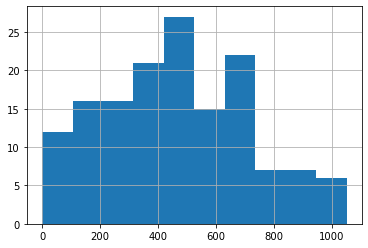

In [42]:
ultra_min.hist(bins=10)

#### нормальное распределение скошенное влево. Как видно из графика определенной части пользователей хвтает до 200 минут в месяц и примерно такой же части,  нужно от 800 до 1000 минут.
#### посчитаем среднее + одно стд. отклонение: 467 + 251 = 718 минут. Добавим к среднему 3 стд. отклонения = 467 + 251*3 = 1220 минут. 99% пользователей необходимо 1220 минут в месяц, лимит в 3000 минут сильно завышен, люди столько просто физически не говорят и это похоже на правду.

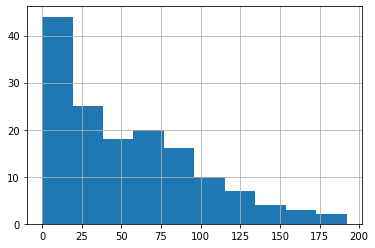

In [43]:
ultra_sms.hist()

####  история с смс аналогична тарифу смарт. распределение пуассона показывает, что большинство смс либо не пользуется, либо нужно немного. 51 + 45*3= 186 смс хватит для 99% пользователей тарифа. Никак не 1000, которая входит в тариф.

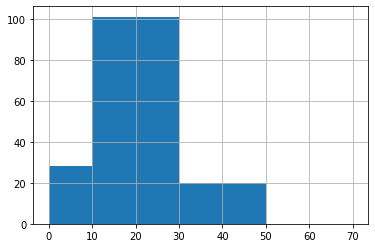

In [44]:
ultra_gb.hist(bins=[0,10,30,50,70])

#### Нормальное распределение. 18,8 + 8,8 = 27,6 gb (из 30 доступных) хватит 83% пользователей, в принципе нормально

### Вывод: Тариф ультра сильно раздут за счет минут и смс, из за этого и обусловлена его высокая стоимость, но людям столько просто не надо, а вот интернет трафика можно накинуть и побольше.

 ## Разберемся, какой тариф выгоднее для оператора связи

### Проверим гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [45]:
from scipy import stats as st
#Н0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
#Н1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

Оценим равенство по двум выборкам

In [46]:
smart_profit = pivot.query('tariff == "smart"').groupby('user_id')['profit'].mean()
ultra_profit = pivot.query('tariff == "ultra"').groupby('user_id')['profit'].mean()

In [47]:
print(smart_profit.agg(['mean','sum','count']))
print(ultra_profit.agg(['mean','sum','count']))

mean       1259.706902
sum      442157.122583
count       351.000000
Name: profit, dtype: float64
mean       2080.751874
sum      310032.029221
count       149.000000
Name: profit, dtype: float64


In [48]:
results = st.ttest_ind(smart_profit, ultra_profit)

In [49]:
results.pvalue

2.1523656497109273e-48

In [50]:
if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Отвергаем нулевую гипотезу


#### Вероятность того, что разница по средней выручке получалась случайно очень мала, следовательно, мы отвергаем гипотезу о равенстве средних вырочек между тарифами, в пользу альтернативной гипотезы

### Проверим гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Н0 - средняя выручка пользователей из Москвы и регионов равны
Н1 - средняя выручка пользователей из Москвы и регионов отличаются

Оценим равенство по двум выборкам

In [51]:
profit_msk = pivot.query('city == "Москва"').groupby('user_id')['profit'].mean()
profit_regions = pivot.query('city != "Москва"').groupby('user_id')['profit'].mean()

In [52]:
print(profit_msk.mean())
print(profit_regions.mean())

1456.2600824259914
1516.257864447827


In [53]:
results = st.ttest_ind(profit_msk, profit_regions)

In [54]:
results.pvalue

0.401230669164635

In [55]:
if results.pvalue < 0.05:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Не получилось отвергнуть нулевую гипотезу


#### Вероятность того, что разница по средней выручке получалась случайно почти 40%, что очень много, следовательно, мы не отвергаем нулевую гипотезу о равенстве средних выручек в двух регионах.

In [56]:
print(smart_profit.agg(['mean','sum','count']))
print(ultra_profit.agg(['mean','sum','count']))

mean       1259.706902
sum      442157.122583
count       351.000000
Name: profit, dtype: float64
mean       2080.751874
sum      310032.029221
count       149.000000
Name: profit, dtype: float64


### ВЫВОД: Исходя из исследования, я могу сделать вывод, что  более выгодный тариф для компании - это тариф ултра, средняя выручка больше почти на 40%, гипотезу о равенстве мы тоже отвергли. В самом тарифе по минутам и смс 99% пользователям хватает лимита, и 87% хватает лимита по инет-трафику. В тарифе смарт с этим похуже.